In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
import matplotlib.pyplot as plt
import numpy as np

data_iter = iter(trainloader)
images, labels = data_iter.next()

img = torchvision.utils.make_grid(images)
img = img / 2 + 0.5
img.numpy()
plt.imshow(np.transpose(img, (1, 2, 0)))
plt.show()

print(' '.join(f"{classes[j]}" for j in labels))

<Figure size 640x480 with 1 Axes>

cat frog cat ship


In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [7]:
for epoch in range(3):
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        images, labels = data
        
        optimizer.zero_grad()
        output = net(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f"[{epoch + 1} {i + 1}] {running_loss}")
            running_loss = 0.0        

[1 2000] 4597.650623321533
[1 4000] 4067.9288923740387
[1 6000] 3509.0443366765976
[1 8000] 3263.0693012475967
[1 10000] 3113.052136361599
[1 12000] 3005.2743387818336
[2 2000] 2867.7809882462025
[2 4000] 2783.236412294209
[2 6000] 2700.0928520560265
[2 8000] 2665.2259188741446
[2 10000] 2614.2934290096164
[2 12000] 2569.1299883127213
[3 2000] 2426.660253472626
[3 4000] 2403.425517760217
[3 6000] 2406.345729112625
[3 8000] 2409.9175434559584
[3 10000] 2349.8434488661587
[3 12000] 2412.800466535613


In [8]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

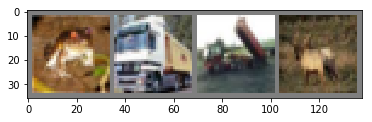

frog truck truck deer


In [9]:
dataiter = iter(testloader)
images, labels = dataiter.next()

img = torchvision.utils.make_grid(images)
img = img / 2 + 0.5
img.numpy()
plt.imshow(np.transpose(img, (1, 2, 0)))
plt.show()

print(' '.join(f"{classes[j]}" for j in labels))

In [10]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [11]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print(' '.join(f"{classes[j]}" for j in predicted))

frog truck truck deer


In [42]:
correct = 0
total = 0

raw_score = dict()
for i in range(len(classes)):
    raw_score[i] = ([], [])

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        for i in range(4):
            for cls_i in range(len(classes)):
                raw_score[cls_i][0].append(1 if cls_i == labels[i] else 0)
                raw_score[cls_i][1].append(outputs[i][cls_i])
            

print(f"{correct} / {total}, {correct/total}")

30771 / 50000, 0.61542


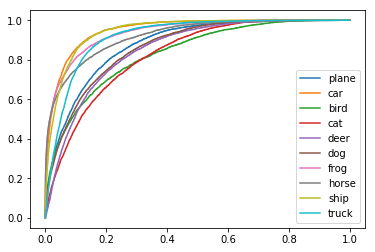

In [46]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(raw_score[i][0], raw_score[i][1])
    plt.plot(fpr[i], tpr[i], label=classes[i])
    
plt.legend()
plt.show()